### EDA

In [53]:
import numpy as np
import pandas as pd
import gc
import copy
import os
import sys

from pathlib import Path
from datetime import datetime, date, time, timedelta
from dateutil import relativedelta

import pyarrow.parquet as pq
import pyarrow as pa

In [ ]:
%%time
train = pd.read_parquet( r"amex\amex_train_20220706.parquet")

In [72]:
# df = pd.read_excel(r"amex-hyperopt-lgb-rev2-spsfr-3kfold-corr75-union2.xlsx")
# df = pd.read_excel(r"amex-hyperopt-lgb-rev2-spsfr-3kfold-corr75-union3.xlsx")
df = pd.read_excel(r"amex-hyperopt-lgb-rev2-spsfr-3kfold-corr75-527feats.xlsx")

In [73]:
df.sort_values(by='mean_loss', ascending=False, inplace=True)

In [74]:
df.head(5)

,params,losses,mean_loss
71,"{'boosting_type': 'gbdt', 'colsample_bytree': ...","[0.7906257795179247, 0.7874062774169696, 0.794...",0.790744
197,"{'boosting_type': 'gbdt', 'colsample_bytree': ...","[0.7904870638160928, 0.7868333163078894, 0.792...",0.790065
72,"{'boosting_type': 'gbdt', 'colsample_bytree': ...","[0.790521966880872, 0.7867358876557876, 0.7929...",0.790059
145,"{'boosting_type': 'gbdt', 'colsample_bytree': ...","[0.7913849102340931, 0.7853770801536164, 0.792...",0.789836
138,"{'boosting_type': 'gbdt', 'colsample_bytree': ...","[0.7905250354832258, 0.7868374299116397, 0.792...",0.789791


<AxesSubplot:ylabel='Frequency'>

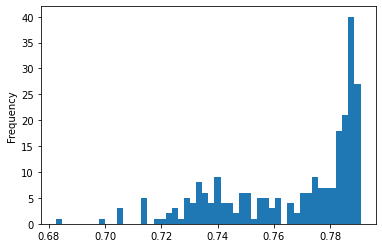

In [75]:
df['mean_loss'].plot(kind='hist', bins=50)

In [76]:
df.iloc[0]['params']

"{'boosting_type': 'gbdt', 'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_bin': 3600, 'max_depth': 17, 'metric': 'auc', 'min_child_samples': 300, 'min_data_in_bin': 2850, 'n_estimators': 1100, 'n_jobs': 4, 'num_leaves': 96, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 0.5, 'reg_lambda': 10, 'subsample': 0.8, 'subsample_freq': 19}"

In [77]:
for i in range(5):
    print(df.iloc[i]['params'])

{'boosting_type': 'gbdt', 'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_bin': 3600, 'max_depth': 17, 'metric': 'auc', 'min_child_samples': 300, 'min_data_in_bin': 2850, 'n_estimators': 1100, 'n_jobs': 4, 'num_leaves': 96, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 0.5, 'reg_lambda': 10, 'subsample': 0.8, 'subsample_freq': 19}
{'boosting_type': 'gbdt', 'colsample_bytree': 0.3, 'learning_rate': 0.03, 'max_bin': 8300, 'max_depth': 18, 'metric': 'auc', 'min_child_samples': 2950, 'min_data_in_bin': 2500, 'n_estimators': 1150, 'n_jobs': 4, 'num_leaves': 256, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 15, 'reg_lambda': 0.01, 'subsample': 0.85, 'subsample_freq': 23}
{'boosting_type': 'gbdt', 'colsample_bytree': 0.1, 'learning_rate': 0.03, 'max_bin': 5000, 'max_depth': 17, 'metric': 'auc', 'min_child_samples': 300, 'min_data_in_bin': 2850, 'n_estimators': 1100, 'n_jobs': 4, 'num_leaves': 96, 'objective': 'binary', 'random_state': 1234, 'reg_alpha': 0.5, 'reg

In [29]:
x_cols = ['B_10|last', 'B_10|mean', 'B_11|last', 'B_11|mean', 'B_11|min', 'B_14|last', 'B_14|min', 'B_15|mean', 'B_16|max', 'B_16|min', 'B_17_mean2std', 'B_17|last', 'B_17|max', 'B_17|mean', 'B_17|min', 'B_18|last', 'B_18|min', 'B_19|last', 'B_19|min', 'B_1|last', 'B_1|max', 'B_1|mean', 'B_1|min', 'B_20|last', 'B_20|max', 'B_20|mean', 'B_20|min', 'B_21|last', 'B_21|max', 'B_22|last', 'B_22|max', 'B_22|mean', 'B_22|min', 'B_23|last', 'B_23|mean', 'B_23|min', 'B_24|last', 'B_24|mean', 'B_25|last', 'B_25|min', 'B_26|last', 'B_28|last', 'B_2|last', 'B_2|mean', 'B_2|min', 'B_30=0.0', 'B_30=1.0', 'B_30=2.0', 'B_30|nunique', 'B_31|nunique', 'B_32|last', 'B_32|max', 'B_33|last', 'B_33|max', 'B_33|mean', 'B_33|min', 'B_37|last', 'B_37|max', 'B_37|mean', 'B_38=4.0', 'B_38=5.0', 'B_38=6.0', 'B_38=7.0', 'B_38|last', 'B_38|nunique', 'B_3|last', 'B_3|max', 'B_3|mean', 'B_3|min', 'B_40|last', 'B_40|min', 'B_41|last', 'B_4_mean2std', 'B_4|last', 'B_4|max', 'B_5|last', 'B_5|mean', 'B_6|last', 'B_6|min', 'B_7|last', 'B_7|max', 'B_7|mean', 'B_7|min', 'B_8|last', 'B_8|max', 'B_8|mean', 'B_8|min', 'B_9|last', 'B_9|max', 'B_9|mean', 'B_9|min', 'D_102|max', 'D_105|max', 'D_106|last', 'D_107|max', 'D_109|mean', 'D_112|last', 'D_113|max', 'D_114=0.0', 'D_114|nunique', 'D_120=1.0', 'D_120|nunique', 'D_122|last', 'D_122|max', 'D_122|min', 'D_123|mean', 'D_128|max', 'D_128|min', 'D_129|last', 'D_129|max', 'D_129|mean', 'D_130|last', 'D_130|max', 'D_131|max', 'D_131|min', 'D_132_mean2std', 'D_132|min', 'D_133|last', 'D_133|max', 'D_133|min', 'D_134|min', 'D_135_mean2std', 'D_139|mean', 'D_140|max', 'D_143|last', 'D_145|last', 'D_39|last', 'D_39|max', 'D_39|mean', 'D_41|last', 'D_41|max', 'D_41|mean', 'D_41|min', 'D_42_mean2std', 'D_42|last', 'D_42|max', 'D_42|mean', 'D_42|min', 'D_43|last', 'D_43|max', 'D_43|mean', 'D_43|min', 'D_44|last', 'D_44|max', 'D_44|mean', 'D_44|min', 'D_45|last', 'D_45|max', 'D_45|mean', 'D_45|min', 'D_46_mean2std', 'D_46|last', 'D_46|mean', 'D_46|min', 'D_47|last', 'D_48|last', 'D_48|max', 'D_48|mean', 'D_48|min', 'D_49_mean2std', 'D_51|last', 'D_51|mean', 'D_52_mean2std', 'D_52|last', 'D_52|max', 'D_52|mean', 'D_52|min', 'D_53_mean2std', 'D_53|last', 'D_53|max', 'D_53|min', 'D_54|last', 'D_55|last', 'D_55|min', 'D_56|min', 'D_58|last', 'D_58|min', 'D_59|last', 'D_59|max', 'D_60|max', 'D_61|last', 'D_61|max', 'D_61|mean', 'D_61|min', 'D_62|last', 'D_62|max', 'D_62|mean', 'D_62|min', 'D_64=U', 'D_65|last', 'D_65|max', 'D_65|mean', 'D_68=1.0', 'D_69|min', 'D_70_mean2std', 'D_70|last', 'D_70|max', 'D_70|min', 'D_72|max', 'D_72|min', 'D_74|last', 'D_74|max', 'D_74|mean', 'D_75|last', 'D_75|max', 'D_75|mean', 'D_77|last', 'D_77|max', 'D_77|mean', 'D_77|min', 'D_78|last', 'D_78|max', 'D_78|mean', 'D_79|max', 'D_81|max', 'D_81|mean', 'D_84|last', 'D_84|max', 'D_84|mean', 'D_89|last', 'D_89|max', 'D_89|mean', 'D_91|last', 'P_2|last', 'P_2|max', 'P_2|mean', 'P_2|min', 'P_3|last', 'P_3|max', 'P_3|mean', 'P_3|min', 'P_4|max', 'P_4|mean', 'P_4|min', 'R_10|last', 'R_10|max', 'R_10|mean', 'R_11|last', 'R_11|max', 'R_11|mean', 'R_12|max', 'R_12|mean', 'R_13_mean2std', 'R_13|last', 'R_13|max', 'R_13|mean', 'R_15|last', 'R_15|max', 'R_15|mean', 'R_16|last', 'R_16|max', 'R_16|mean', 'R_17|last', 'R_17|max', 'R_18|max', 'R_19|last', 'R_19|min', 'R_1|last', 'R_1|max', 'R_1|mean', 'R_1|min', 'R_20|last', 'R_20|max', 'R_20|mean', 'R_21|last', 'R_22|max', 'R_24|last', 'R_24|max', 'R_24|mean', 'R_25|max', 'R_26_mean2std', 'R_27|last', 'R_27|max', 'R_27|mean', 'R_27|min', 'R_2|last', 'R_2|max', 'R_2|mean', 'R_2|min', 'R_3|last', 'R_3|max', 'R_3|mean', 'R_3|min', 'R_4|last', 'R_4|max', 'R_4|mean', 'R_4|min', 'R_5|last', 'R_5|max', 'R_5|mean', 'R_6|last', 'R_6|max', 'R_6|mean', 'R_7|last', 'R_7|max', 'R_7|mean', 'R_8|last', 'R_8|max', 'R_8|mean', 'R_9_mean2std', 'S_11|mean', 'S_12|max', 'S_15|last', 'S_15|max', 'S_15|mean', 'S_17|min', 'S_20|max', 'S_22|last', 'S_22|max', 'S_22|mean', 'S_23|last', 'S_23|max', 'S_23|mean', 'S_25|last', 'S_25|mean', 'S_25|min', 'S_26|last', 'S_27_mean2std', 'S_3|last', 'S_3|max', 'S_3|mean', 'S_3|min', 'S_6|max', 'S_6|min', 'S_7|last', 'S_7|max', 'S_7|mean', 'S_7|min', 'S_8|last', 'S_8|mean', 'S_8|min', 'S_9|max', 'log_B_11|last', 'log_B_11|max', 'log_B_11|mean', 'log_B_11|min', 'log_B_12|last', 'log_B_12|max', 'log_B_18|last', 'log_B_18|max', 'log_B_18|mean', 'log_B_18|min', 'log_B_21|last', 'log_B_21|mean', 'log_B_22|last', 'log_B_22|max', 'log_B_22|mean', 'log_B_22|min', 'log_B_23|last', 'log_B_23|max', 'log_B_23|min', 'log_B_24|last', 'log_B_24|mean', 'log_B_26|last', 'log_B_26|max', 'log_B_26|mean', 'log_B_3|last', 'log_B_3|max', 'log_B_3|mean', 'log_B_3|min', 'log_B_40|last', 'log_B_40|max', 'log_B_40|mean', 'log_B_40|min', 'log_B_41|max', 'log_B_4|last', 'log_B_4|max', 'log_B_4|mean', 'log_B_4|min', 'log_B_5|last', 'log_B_9|last', 'log_B_9|max', 'log_B_9|mean', 'log_B_9|min', 'log_D_102|max', 'log_D_107|mean', 'log_D_107|min', 'log_D_113|min', 'log_D_118|mean', 'log_D_123|last', 'log_D_125|min', 'log_D_131|last', 'log_D_131|min', 'log_D_133|last', 'log_D_133|min', 'log_D_39|last', 'log_D_39|max', 'log_D_39|min', 'log_D_41|last', 'log_D_41|max', 'log_D_41|min', 'log_D_43|last', 'log_D_43|max', 'log_D_43|mean', 'log_D_43|min', 'log_D_44|last', 'log_D_44|max', 'log_D_44|mean', 'log_D_44|min', 'log_D_45|last', 'log_D_45|max', 'log_D_45|mean', 'log_D_45|min', 'log_D_49|last', 'log_D_51|max', 'log_D_51|min', 'log_D_60|min', 'log_S_5|mean']
len(x_cols)

a = ['P_2|min', 'log_B_9|last', 'P_2|mean', 'log_B_18|last', 'D_44|last', 'R_1|max', 'D_75|last', 'B_9|last', 'P_2|last', 'B_23|last', 'B_9|max', 'D_48|mean', 'log_B_3|max', 'B_1|last', 'B_33|mean', 'log_B_11|last', 'log_D_44|max', 'log_B_3|last', 'log_D_44|mean', 'D_44|max', 'P_2|max', 'B_33|last', 'B_9|mean', 'B_18|last', 'S_25|min', 'R_1|last', 'R_1|mean', 'B_20|last', 'log_B_9|max', 'S_25|mean', 'B_18|mean', 'log_B_18|min', 'log_B_18|mean', 'B_37|mean', 'B_17|mean', 'B_20|mean', 'log_B_22|max', 'B_37|last', 'D_48|last', 'D_45|max', 'log_D_44|last', 'B_18|max', 'D_42|min', 'log_B_23|last', 'log_D_41|last', 'R_2|max', 'log_D_39|last', 'R_6|mean', 'P_3|last', 'R_3|mean', 'S_23|mean', 'R_2|last', 'B_7|last', 'D_39|last', 'B_2|last', 'P_3|mean', 'B_11|last', 'D_41|last', 'B_10|last', 'B_3|last', 'D_42|mean', 'S_3|mean', 'D_44|mean', 'D_41|max', 'D_61|max', 'R_3|last', 'B_8|last', 'D_39|max', 'D_45|min', 'B_18|min', 'R_4|mean', 'D_61|last', 'S_7|mean', 'D_42|last', 'B_20|max', 'S_3|last', 'B_5|last', 'R_8|max', 'R_5|max', 'S_3|min', 'D_48|max', 'B_4|last', 'log_B_4|last', 'log_D_39|max', 'D_84|mean', 'log_D_43|mean', 'D_62|max', 'S_3|max', 'log_D_45|mean', 'R_16|mean', 'R_10|mean', 'log_D_45|min', 'S_7|max', 'B_11|mean', 'P_3|min', 'R_6|last', 'B_2|mean', 'D_62|mean', 'R_8|mean', 'R_2|mean', 'log_D_45|last', 'D_74|last', 'log_B_5|mean', 'D_45|mean', 'log_B_26|max', 'D_42|max', 'S_23|last', 'log_D_45|max', 'log_B_5|last', 'log_D_41|max', 'S_23|max', 'R_3|max', 'R_27|mean', 'P_4|mean', 'D_46|last', 'B_5|mean', 'D_52|max', 'R_27|max', 'S_8|mean', 'S_8|last', 'D_75|max', 'D_55|last', 'D_43|mean', 'S_22|last', 'S_7|last', 'D_78|last', 'D_43|last', 'B_26|last', 'R_5|last', 'D_112|last', 'log_B_22|mean', 'D_53|last', 'D_65|last', 'B_6|last', 'R_7|last', 'log_D_43|last', 'P_4|max', 'D_46|mean', 'R_15|mean', 'D_46|min', 'D_65|max', 'R_27|last', 'R_6|max', 'S_25|last', 'D_47|last', 'R_10|max', 'log_B_26|last', 'D_62|last', 'S_15|max', 'B_22|last']

b = ['P_2|min', 'P_2|mean', 'log_B_9|last', 'D_44|last', 'log_B_18|last', 'D_75|last', 'R_1|max', 'P_2|last', 'D_48|mean', 'B_23|last', 'B_9|max', 'log_B_3|max', 'B_9|last', 'B_33|mean', 'B_1|last', 'log_D_44|max', 'log_B_11|last', 'log_D_44|mean', 'log_B_3|last', 'B_9|mean', 'R_1|last', 'D_44|max', 'P_2|max', 'B_18|last', 'B_18|mean', 'B_20|last', 'log_B_4|last', 'B_33|last', 'R_1|mean', 'B_37|mean', 'log_B_18|min', 'log_B_22|max', 'log_B_18|mean', 'B_20|mean', 'log_B_9|max', 'R_7|mean', 'S_25|mean', 'D_48|max', 'D_48|last', 'B_17|mean', 'D_61|last', 'B_18|max', 'B_3|last', 'log_D_44|last', 'P_3|last', 'B_10|last', 'D_44|mean', 'D_42|max', 'R_2|last', 'B_2|last', 'R_8|max', 'B_37|last', 'S_23|last', 'D_42|mean', 'D_45|max', 'S_23|mean', 'D_61|max', 'R_2|max', 'D_75|mean', 'log_D_41|last', 'R_4|mean', 'D_42|min', 'D_45|last', 'log_D_39|last', 'S_3|last', 'R_10|mean', 'D_39|last', 'R_3|mean', 'B_11|last', 'B_5|mean', 'S_7|last', 'S_7|max', 'log_D_45|max', 'log_D_39|max', 'R_6|mean', 'D_39|max', 'D_62|max', 'B_8|last', 'P_3|mean', 'D_41|max', 'R_6|last', 'S_7|mean', 'P_3|min', 'R_2|mean', 'B_1|mean', 'D_41|last', 'S_3|mean', 'D_52|min', 'R_5|mean', 'S_15|mean', 'B_37|min', 'D_62|mean', 'D_74|last', 'S_3|min', 'S_8|min', 'log_B_26|last', 'D_112|last', 'log_D_41|max', 'R_3|last', 'log_D_45|mean', 'S_3|max', 'B_11|mean', 'D_46|last', 'B_8|min', 'D_42|last', 'R_7|max', 'D_84|mean', 'B_8|mean', 'B_7|last', 'D_44|min', 'R_4|last', 'D_62|min', 'B_7|mean', 'D_78|last', 'S_8|max', 'R_3|max', 'R_16|mean', 'log_D_43|mean', 'D_53|max', 'D_46|mean', 'D_43|last', 'log_B_5|last', 'R_6|max', 'D_41|mean', 'B_26|max', 'D_43|mean', 'D_54|last', 'P_4|mean', 'log_B_23|last', 'R_5|max', 'R_8|mean', 'D_128|max', 'B_2|min', 'B_4|last', 'log_B_22|last', 'B_18|min', 'log_B_40|min', 'S_23|max', 'S_15|max', 'log_D_43|max', 'D_52|last', 'S_7|min', 'S_25|min', 'D_46|min', 'log_D_45|min', 'B_22|last', 'D_45|mean', 'D_65|mean', 'D_65|last', 'B_40|mean']

c = ['P_2|min', 'P_2|mean', 'log_B_9|last', 'D_44|last', 'log_B_18|last', 'B_9|max', 'R_1|max', 'D_75|last', 'B_9|last', 'D_48|mean', 'B_23|last', 'P_2|last', 'log_B_3|max', 'B_1|last', 'B_33|mean', 'log_D_44|last', 'log_D_44|max', 'D_44|max', 'D_48|last', 'log_B_11|last', 'R_1|last', 'B_9|mean', 'log_D_44|mean', 'P_2|max', 'B_33|last', 'R_1|mean', 'B_20|last', 'log_B_18|min', 'B_37|mean', 'B_18|mean', 'log_B_22|max', 'log_B_18|mean', 'B_20|mean', 'B_3|last', 'S_25|mean', 'B_17|mean', 'D_48|max', 'B_30=1.0', 'log_B_9|max', 'B_11|last', 'B_37|last', 'R_2|max', 'R_2|last', 'D_42|mean', 'B_18|max', 'P_3|last', 'R_10|mean', 'R_3|mean', 'D_42|min', 'D_61|max', 'R_6|mean', 'B_2|last', 'B_18|last', 'D_42|last', 'D_39|last', 'D_41|last', 'B_10|last', 'R_6|max', 'D_78|last', 'D_44|mean', 'log_D_41|last', 'B_2|mean', 'R_8|max', 'D_61|last', 'D_45|max', 'D_75|mean', 'D_42|max', 'S_3|mean', 'log_D_43|mean', 'P_3|min', 'P_3|mean', 'log_D_39|last', 'D_39|max', 'S_23|last', 'S_22|last', 'R_2|mean', 'log_B_3|last', 'R_5|max', 'S_7|mean', 'log_D_45|mean', 'log_D_45|last', 'S_8|last', 'log_B_26|mean', 'D_74|last', 'B_18|min', 'S_3|max', 'S_7|max', 'B_7|last', 'log_D_45|max', 'R_3|last', 'S_3|last', 'log_B_3|mean', 'D_84|last', 'S_23|mean', 'S_15|mean', 'log_B_26|last', 'B_17|last', 'R_3|max', 'B_8|last', 'S_3|min', 'P_4|mean', 'R_6|last', 'R_5|mean', 'D_65|last', 'R_4|mean', 'B_8|mean', 'R_16|mean', 'D_65|max', 'B_22|last', 'R_5|last', 'B_26|mean', 'D_45|last', 'D_61|mean', 'log_B_5|last', 'B_26|last', 'D_45|min', 'S_7|last', 'log_B_23|last', 'R_3|min', 'B_11|mean', 'D_62|mean', 'D_62|last', 'S_13|last', 'B_4|last', 'B_5|last', 'D_62|max', 'D_53|max', 'S_8|mean', 'log_D_43|min', 'D_78|max', 'R_7|last', 'log_D_43|last', 'S_7|min', 'D_62|min', 'R_10|max', 'B_40|mean', 'log_B_40|min', 'D_46|last', 'log_B_11|mean', 'D_112|last', 'R_8|mean', 'log_D_39|max', 'log_B_4|last', 'D_43|mean', 'R_7|max', 'log_D_45|min', 'B_19|last', 'D_47|min', 'S_15|max', 'B_1|mean']

x_cols1 = list(set(x_cols + a + b + c) - set(['customer_ID', 'S_2', 'D_66|last', 'log_B_28|max', 'log_B_28|mean', 'target']))
x_cols1.sort()
print(x_cols1)
len(x_cols1)

['B_10|last', 'B_10|mean', 'B_11|last', 'B_11|mean', 'B_11|min', 'B_14|last', 'B_14|min', 'B_15|mean', 'B_16|max', 'B_16|min', 'B_17_mean2std', 'B_17|last', 'B_17|max', 'B_17|mean', 'B_17|min', 'B_18|last', 'B_18|max', 'B_18|mean', 'B_18|min', 'B_19|last', 'B_19|min', 'B_1|last', 'B_1|max', 'B_1|mean', 'B_1|min', 'B_20|last', 'B_20|max', 'B_20|mean', 'B_20|min', 'B_21|last', 'B_21|max', 'B_22|last', 'B_22|max', 'B_22|mean', 'B_22|min', 'B_23|last', 'B_23|mean', 'B_23|min', 'B_24|last', 'B_24|mean', 'B_25|last', 'B_25|min', 'B_26|last', 'B_26|max', 'B_26|mean', 'B_28|last', 'B_2|last', 'B_2|mean', 'B_2|min', 'B_30=0.0', 'B_30=1.0', 'B_30=2.0', 'B_30|nunique', 'B_31|nunique', 'B_32|last', 'B_32|max', 'B_33|last', 'B_33|max', 'B_33|mean', 'B_33|min', 'B_37|last', 'B_37|max', 'B_37|mean', 'B_37|min', 'B_38=4.0', 'B_38=5.0', 'B_38=6.0', 'B_38=7.0', 'B_38|last', 'B_38|nunique', 'B_3|last', 'B_3|max', 'B_3|mean', 'B_3|min', 'B_40|last', 'B_40|mean', 'B_40|min', 'B_41|last', 'B_4_mean2std', 'B

418

In [28]:
set(x_cols1)-set(x_cols)

{'B_18|max',
 'B_18|mean',
 'B_26|max',
 'B_26|mean',
 'B_37|min',
 'B_40|mean',
 'D_47|min',
 'S_13|last',
 'S_8|max',
 'log_B_5|mean'}

In [62]:
a=['P_2__last', 'P_2__mean', 'B_9__last__log', 'D_48__last', 'B_2__last__log', 'D_44__last', 'P_2__max', 'B_18__last', 'P_2__min', 'B_9__last', 'B_33__last', 'R_1__std', 'R_1__max', 'B_20__last__log', 'R_1__mean__log', 'B_11__last', 'P_2__first', 'D_44__last__log', 'B_7__last', 'B_2__last2max', 'B_9__max', 'B_37__last', 'D_61__last', 'B_3__last__log', 'B_9__mean__log', 'D_44__mean__log', 'B_2__mean', 'D_75__last__log', 'B_33__last2max', 'R_10__std', 'B_19__last__log', 'B_18__min', 'D_75__mean__log', 'D_42__max', 'B_11__last__log', 'R_1__mean', 'R_1__last__log', 'R_2__mean', 'D_42__mean', 'R_2__last__log', 'D_42__first', 'R_10__mean', 'R_1__last', 'S_3__last', 'R_2__range', 'D_44__std', 'D_44__max', 'D_42__last', 'D_39__last', 'B_4__last__log', 'B_2__last', 'D_42__min', 'P_3__mean', 'B_22__last', 'D_48__max', 'D_41__last__log', 'D_41__last', 'R_1__range', 'B_25__last2max', 'D_39__last__log', 'B_3__std', 'S_3__max', 'B_9__last2max', 'P_3__last', 'S_8__mean', 'D_55__last2max', 'R_2__last', 'S_3__mean', 'B_4__range', 'B_1__last', 'D_44__mean', 'B_3__max', 'D_45__last__log', 'B_3__last', 'B_14__last2max', 'D_77__first', 'D_45__last', 'B_4__std', 'B_23__last__log', 'R_3__mean__log', 'B_23__last', 'S_7__min', 'B_37__mean', 'S_7__last', 'S_7__mean', 'R_5__last__log', 'D_65__last__log', 'D_41__range', 'B_26__last__log', 'P_3__min', 'B_4__last', 'B_8__mean', 'B_2__min', 'D_55__std', 'R_3__max', 'B_9__mean', 'R_4__mean__log', 'D_39__std', 'D_44__last2max', 'D_47__mean', 'B_11__last2max', 'B_19__mean__log', 'D_48__min', 'D_75__last', 'S_7__max', 'D_45__first', 'B_30=0.0', 'D_43__mean__log', 'R_3__last__log', 'D_115__last__log', 'D_39__max', 'D_65__mean__log', 'D_58__last__log', 'D_47__last', 'R_6__last__log', 'D_39__range', 'R_2__mean__log', 'R_5__mean', 'R_4__last', 'D_44__min', 'R_3__min', 'D_45__max', 'D_51__max', 'S_3__min', 'D_74__std', 'B_28__last2max', 'D_77__min', 'B_37__max', 'D_75__std', 'D_47__min', 'D_43__mean', 'S_8__last', 'S_7__first', 'R_8__mean__log', 'R_2__std', 'D_122__mean', 'B_22__mean__log', 'D_128__max', 'D_84__last', 'S_3__first', 'D_43__min', 'D_55__first', 'B_19__range', 'D_70__min', 'B_26__mean__log', 'D_74__last__log', 'R_4__mean', 'D_112__last2max', 'R_2__max', 'B_6__last2max', 'B_2__mean__log', 'R_6__mean', 'B_22__last__log', 'D_61__mean', 'B_8__last__log', 'S_8__min', 'B_3__mean', 'D_52__last', 'D_47__first', 'D_78__mean', 'B_10__last2max', 'D_45__min', 'D_70__mean__log', 'D_128__min', 'D_84__last__log', 'D_45__mean__log', 'D_115__mean__log', 'B_8__first', 'B_1__last2max', 'D_43__first', 'D_43__last', 'R_17__max', 'D_79__std', 'B_23__mean__log', 'B_16__std', 'D_43__last__log', 'D_59__last', 'R_11__mean__log', 'D_84__range', 'D_44__range', 'S_20__std', 'D_43__max', 'D_89__range', 'R_8__last', 'D_51__last', 'D_62__last', 'R_3__mean', 'D_54__range', 'R_5__last', 'R_3__last', 'R_3__first', 'B_21__mean__log', 'D_59__min', 'D_78__last__log', 'S_7__range', 'D_70__last__log', 'R_21__std', 'B_12__last__log', 'S_3__std', 'B_18__mean__log']

b=['P_2__mean', 'P_2__last', 'B_9__last__log', 'D_48__last', 'B_2__last__log', 'D_44__last', 'B_18__last', 'P_2__max', 'B_9__last', 'B_9__max', 'R_1__max', 'R_1__std', 'P_2__min', 'B_20__last__log', 'B_11__last', 'P_2__first', 'B_37__last', 'D_44__mean__log', 'D_44__last__log', 'B_33__last', 'B_7__last', 'D_61__last', 'B_3__last__log', 'D_48__mean', 'B_23__last', 'B_2__last2max', 'R_1__mean__log', 'R_1__last', 'R_1__mean', 'D_42__max', 'B_9__mean__log', 'B_2__mean', 'B_19__last__log', 'B_33__last2max', 'R_10__std', 'B_18__min', 'R_10__mean__log', 'D_75__mean__log', 'B_11__last__log', 'R_1__last__log', 'D_42__mean', 'D_42__last', 'R_2__last__log', 'D_48__max', 'R_2__mean', 'D_44__max', 'B_2__last', 'B_3__last', 'R_2__last', 'R_1__range', 'D_42__first', 'R_6__last', 'P_3__mean', 'D_45__last__log', 'S_3__mean', 'D_41__last', 'D_39__last', 'S_25__range', 'R_2__range', 'P_3__last', 'B_14__last2max', 'B_9__mean', 'S_3__last', 'B_1__last', 'B_4__last', 'B_37__last2max', 'D_48__min', 'R_6__mean__log', 'D_65__last__log', 'B_37__mean', 'D_44__range', 'R_3__mean', 'D_39__last__log', 'R_3__min', 'D_45__first', 'D_45__max', 'D_41__last__log', 'R_3__mean__log', 'S_7__last', 'B_3__std', 'D_55__last2max', 'B_18__last__log', 'B_2__min', 'R_6__mean', 'B_4__last__log', 'B_26__last__log', 'P_3__min', 'D_42__min', 'B_23__last__log', 'S_3__min', 'R_3__max', 'D_47__mean', 'R_4__max', 'B_8__first', 'S_7__max', 'D_112__last__log', 'D_39__std', 'S_7__mean', 'S_3__max', 'D_55__last__log', 'D_44__mean', 'S_8__mean', 'D_41__range', 'D_43__mean__log', 'B_22__last', 'D_44__last2max', 'D_45__mean__log', 'B_4__last2max', 'B_18__mean', 'D_39__range', 'S_15__mean', 'D_46__mean', 'D_61__mean', 'D_41__std', 'D_45__min', 'D_44__std', 'R_2__mean__log', 'B_19__last', 'B_4__range', 'D_43__last', 'R_3__last', 'S_15__max', 'B_11__last2max', 'B_4__std', 'D_112__last2max', 'D_43__last__log', 'D_39__max', 'D_43__mean', 'B_25__last2max', 'B_8__mean', 'D_51__mean__log', 'S_7__min', 'B_1__last2max', 'R_2__std', 'D_43__min', 'B_26__mean__log', 'R_8__mean', 'S_8__min', 'R_3__last__log', 'B_8__max', 'R_6__last__log', 'P_4__mean', 'S_3__std', 'D_47__last', 'B_11__max', 'R_4__std', 'B_28__last2max', 'S_13__min', 'D_77__min', 'D_41__max', 'B_6__last2max', 'B_4__mean', 'D_51__mean', 'R_11__mean__log', 'S_25__last2max', 'D_51__last', 'R_2__max', 'R_6__range', 'B_16__last__log', 'R_16__mean__log', 'B_8__mean__log', 'B_9__last2max', 'R_3__std', 'D_128__last__log', 'S_8__last', 'R_11__mean', 'S_25__std', 'D_62__min', 'D_77__mean__log', 'D_39__mean', 'R_7__last__log', 'D_75__std', 'S_11__min', 'B_22__mean', 'S_5__last__log', 'R_11__std', 'B_4__max', 'R_10__last', 'S_25__last', 'D_45__mean', 'D_47__max', 'D_45__last', 'R_8__last', 'S_3__first', 'P_4__mean__log', 'D_65__mean__log', 'P_4__max', 'R_4__last', 'R_27__min', 'R_5__last', 'D_70__last', 'R_13__last', 'D_74__range', 'D_112__mean__log', 'B_22__last__log', 'P_2__range', 'D_79__max', 'R_16__mean', 'P_4__first', 'S_7__first']

len(set(a)|set(b))

260